# Import libraries

* Pillow, Scikit Learn, Keras, TQDM, Matplot...

In [23]:
from PIL import Image
from PIL import ImageFile
from PIL import ImageOps
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


In [24]:
from os import listdir
from os.path import isfile, join

cloud_root = "./spaceknow-clouds-test"

cloud_roots = ['China - Fuzhou', 'China - Jiudongshan', 'China - Shishi', 'China - Songjiang']

cloud_folder = [list(map(lambda x: cloud_root + '/' + cr + '/' + f + '/' + x, listdir(cloud_root + '/' + cr + '/' + f)))
                    for cr in cloud_roots
                        for f in listdir(cloud_root + '/' + cr)]
nb_classes = len(cloud_folder)
print(nb_classes, cloud_folder)

8 [['./spaceknow-clouds-test/China - Fuzhou/20150805_024524_0906/20150805_024524_0906_visual.tif', './spaceknow-clouds-test/China - Fuzhou/20150805_024524_0906/20150805_024524_0906_visual_clouds.png', './spaceknow-clouds-test/China - Fuzhou/20150805_024524_0906/20150805_024524_0906_visual.jpg'], ['./spaceknow-clouds-test/China - Fuzhou/20140926_022050_090b/20140926_022050_090b_visual.tif', './spaceknow-clouds-test/China - Fuzhou/20140926_022050_090b/20140926_022050_090b_visual.jpg', './spaceknow-clouds-test/China - Fuzhou/20140926_022050_090b/20140926_022050_090b_visual_clouds.png'], ['./spaceknow-clouds-test/China - Jiudongshan/20150917_020427_1_0b0b/20150917_020427_1_0b0b_visual.jpg', './spaceknow-clouds-test/China - Jiudongshan/20150917_020427_1_0b0b/20150917_020427_1_0b0b_visual.tif', './spaceknow-clouds-test/China - Jiudongshan/20150917_020427_1_0b0b/20150917_020427_1_0b0b_visual_clouds.png'], ['./spaceknow-clouds-test/China - Jiudongshan/20151108_050353_0c07/20151108_050353_0c07_

In [25]:
image_w = 32
image_h = 32

step_w = 16
step_h = 16

In [33]:
import random

def chooseOne(X, ratio):
    Xret = []

    rands = random.sample(range(len(X)), int(len(X) * ratio))

    for idx in rands:
        Xret.append(X[idx])
    return Xret

def choose(X, Y, ratio):
    Xret = []
    Yret = []
    
    rands = random.sample(range(len(X)), int(len(X) * ratio))

    for idx in rands:
        Xret.append(X[idx])
        Yret.append(Y[idx])
    return Xret, Yret

def read_data(pairs, ratio = 1.0):
    X = []
    Y = []
    
    inputImgPath = list(filter(lambda x: x.endswith(".jpg"), pairs))[0]
    answerImgPath = list(filter(lambda x: x.endswith(".png"), pairs))[0]
    img = Image.open(inputImgPath)
    img = img.convert("RGB")

    answer = Image.open(answerImgPath)
    answer = answer.convert("L")
    
    size = img.size
    
    wmax = size[0]
    hmax = size[1]
    
    for h in range(0, hmax - (hmax % step_h), step_h):
        for w in range(0, wmax - (wmax % step_w), step_w):
            area = (w, h, w + image_w, h + image_h)
            croppedImg = img.crop(area)
            croppedAnswer = answer.crop(area)
            
            if ((255 - np.array(croppedImg)).sum() > 0):
                X.append(np.asarray(croppedImg))
                Y.append(np.asarray(croppedAnswer))
    
    if (ratio < 1.0):
        return choose(X, Y, ratio)
    return X, Y

def make_answer(Yarr):
    Y = []
    for y in Yarr:
        Y.append(y.sum())
    Y = np.array(Y).astype("float")
    Y /= np.max(Y)
    #print(len(list(filter(lambda x: x >= 0.5, Y))) / len(Y))
    Y = np.array(list(map(lambda x: [0, 1] if x >= 0.5 else [1, 0], Y)))
    return Y

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.accuracy = []
        
    def on_epoch_end(self, batch, logs = {}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
def plot_result(folder):
    X = []
    Y = []

    inputImgPath = list(filter(lambda x: x.endswith(".jpg"), folder))[0]
    answerImgPath = list(filter(lambda x: x.endswith(".png"), folder))[0]
    img = Image.open(inputImgPath)
    img = img.convert("RGB")

    answer = Image.open(answerImgPath)
    answer = answer.convert("L")

    size = img.size

    wmax = size[0]
    hmax = size[1]

    tp = []
    tn = []
    fp = []
    fn = []

    for hidx, h in enumerate(range(0, hmax - (hmax % step_h), step_h)):
        for widx, w in enumerate(range(0, wmax - (wmax % step_w), step_w)):
            area = (w, h, w + image_w, h + image_h)
            croppedImg = img.crop(area)
            croppedAnswer = answer.crop(area)

            x = np.asarray(croppedImg)
            y = np.asarray(croppedAnswer)

            y = make_answer([y])
            ans = model.predict_classes(np.asarray([x.astype('float') / 256]), verbose = 0)

            if (np.argmax(y) == 1 and ans == 1):
                tp.append([widx, hidx])
            elif (np.argmax(y) == 0 and ans == 1):
                tn.append([widx, hidx])
            elif (np.argmax(y) == 0 and ans == 0):
                fn.append([widx, hidx])
            else:
                fp.append([widx, hidx])
                
    plt.clf()

    ntp = len(tp)
    ntn = len(tn)
    nfp = len(fp)
    nfn = len(fn)
    
    print("TP ratio: {}, FN ratio: {}".format(ntp / (ntp + nfp), nfn / (ntn + nfn)))
    
    def draw(points, color):
        plt.scatter([x[0] for x in points], [y[1] for y in points], s = 1, color = color, marker=',')

    draw(tp, 'green')
    draw(tn, 'blue')
    draw(fp, 'red')
    draw(fn, 'yellow')
    plt.show()
    
def show_result(folder):
    plot_result(folder)
    answerImgPath = list(filter(lambda x: x.endswith(".png"), folder))[0]
    img = Image.open(answerImgPath)
    img.convert("L")
    img = img.rotate(180)
    img = ImageOps.mirror(img)

    imshow(img)
    
def findMaximumRatio(n, m, rate):
    countedN = 0
    countedM = 0
    
    for i in range(1, n + 1):
        if (i / rate > m):
            return countedN / n, countedM / m
        else:
            countedN = int(i)
            countedM = int(i / rate)
    
    return countedN / n, countedM / m
    
def prepare_set(X, Y, ratio):
    zipped = list(zip(X, Y))
    
    trueSet = list(filter(lambda x: all(item == True for item in x[1] == [0, 1]), zipped))
    falseSet = list(filter(lambda x: all(item == True for item in x[1] == [1, 0]), zipped))
    tratio, fratio = findMaximumRatio(len(trueSet), len(falseSet), ratio)
    
    newTX, newTY = choose([x[0] for x in trueSet], [x[1] for x in trueSet], tratio)
    newFX, newFY = choose([x[0] for x in falseSet], [x[1] for x in falseSet], fratio)
    
    newX = newTX + newFX
    newY = newTY + newFY
    
    return np.array(newX), np.array(newY)

In [34]:
X = []
Yorig = []

#cf = chooseOne(cloud_folder, 0.25)

for pairs in tqdm(cloud_folder):
    X_, Yorig_ = read_data(pairs, 0.5)
    
    X += X_
    Yorig += Yorig_

print("Data cnt: %d" % len(X))

X = np.array(X)
Yorig = np.array(Yorig)
Y = make_answer(Yorig)

X, Y = prepare_set(np.asarray(X), np.asarray(Y), 1.0 / 3)

print(len(X) / len(Y))

100%|██████████| 8/8 [00:57<00:00,  6.31s/it]


Data cnt: 257549
1.0


In [35]:
print(len(list(filter(lambda x: x[1] == 0, Y))) / len(Y))

0.75


# Data 준비 단계 - 2 (Train/Test셋으로 구분)

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
print("ok, ", len(X_train), len(X_test))

ok,  103611 34537


In [40]:
X_train = X_train.astype("float") / 256
X_test = X_test.astype("float") / 256
print('X_train shape: ', X_train.shape)
print('num categories: ', nb_classes)

X_train shape:  (103611, 32, 32, 3)
num categories:  8


In [41]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding = 'same', activation = 'relu',
                 input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(384, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [42]:
history = LossHistory()
history.init()

model.fit(X_train, y_train, batch_size = 32, epochs = 50, callbacks = [history])

score = model.evaluate(X_test, y_test)
print()
print('loss = ', score[0])
print('accuracy = ', score[1])

#    inputs = [categories[i] for i in model.predict_classes(X_test)]
#    answer = [categories[np.argmax(bits)] for bits in y_test]
#    print()
#    print(np.sum(np.array(inputs) == np.array(answer)) / np.size(inputs))

Epoch 1/50
103611/103611 [==============================] - 20s - loss: 0.3712 - acc: 0.8286    
Epoch 2/50
103611/103611 [==============================] - 20s - loss: 0.2973 - acc: 0.8758    
Epoch 3/50
103611/103611 [==============================] - 20s - loss: 0.2640 - acc: 0.8892    
Epoch 4/50
103611/103611 [==============================] - 20s - loss: 0.2491 - acc: 0.8949    
Epoch 5/50
103611/103611 [==============================] - 20s - loss: 0.2339 - acc: 0.9001    
Epoch 6/50
103611/103611 [==============================] - 20s - loss: 0.2123 - acc: 0.9111    
Epoch 7/50
103611/103611 [==============================] - 20s - loss: 0.2061 - acc: 0.9140    
Epoch 8/50
103611/103611 [==============================] - 20s - loss: 0.1984 - acc: 0.9169    
Epoch 9/50
103611/103611 [==============================] - 20s - loss: 0.1969 - acc: 0.9180    
Epoch 10/50
103611/103611 [==============================] - 20s - loss: 0.1895 - acc: 0.9211    
Epoch 11/50
103611/103611 [==

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

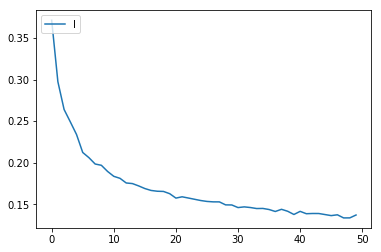

In [43]:
plt.plot(history.losses)
plt.legend('loss', loc = 'upper left')
plt.show()

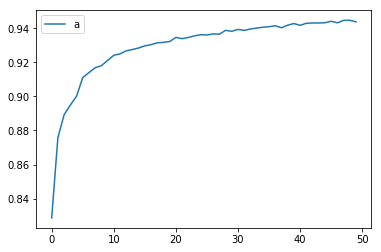

In [44]:
plt.plot(history.accuracy)
plt.legend('accuracy', loc = 'upper left')
plt.show()

In [45]:
Xrem = []
Yrem = []

for pairs in cloud_folder:
    (Xrem, Yrem) = read_data(pairs)
    Xrem = np.array(Xrem)
    Yrem = make_answer(Yrem)
    Xrem = Xrem.astype("float") / 256

    score = model.evaluate(Xrem, Yrem)
    print('loss = ', score[0])
    print('accuracy = ', score[1])

61504/62012 [============================>.] - ETA: 0sloss =  0.14470468634
accuracy =  0.943123911501
52832/53030 [============================>.] - ETA: 0sloss =  0.12770543925
accuracy =  0.956364322082
29920/30038 [============================>.] - ETA: 0sloss =  0.139616069436
accuracy =  0.945568946002
127040/127117 [============================>.] - ETA: 0sloss =  0.0102176492188
accuracy =  0.997049961846
120128/120745 [============================>.] - ETA: 0sloss =  0.0580559572036
accuracy =  0.978930804588
61248/61251 [============================>.] - ETA: 0sloss =  0.264785512811
accuracy =  0.887658976996
30048/30587 [============================>.] - ETA: 0sloss =  0.372593061831
accuracy =  0.843332134567
30016/30323 [============================>.] - ETA: 0sloss =  0.128179581151
accuracy =  0.961712231639


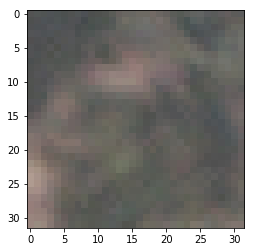

In [46]:


restoreX_test = (Xrem * 256).astype("uint8")

%matplotlib inline
imshow(np.asarray(restoreX_test[6480]))

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.7161236100336178, FN ratio: 0.9867908485100156


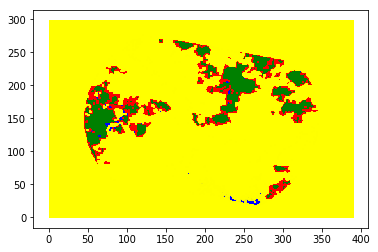

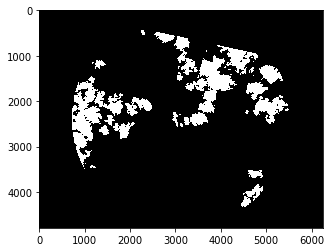

In [47]:
show_result(cloud_folder[0])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.72486699371243, FN ratio: 0.9936481429018742


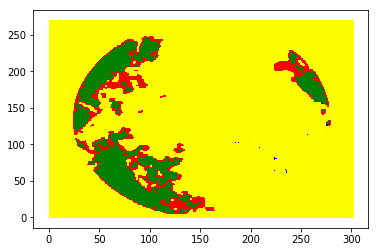

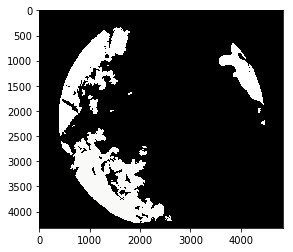

In [48]:
show_result(cloud_folder[1])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.8235971696560803, FN ratio: 0.9894774058859183


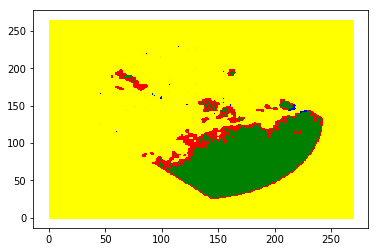

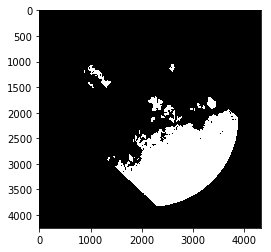

In [49]:
show_result(cloud_folder[2])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.3282828282828283, FN ratio: 0.9990038848490885


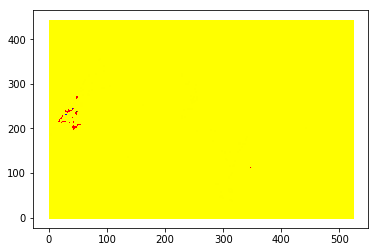

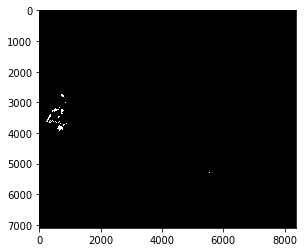

In [50]:
show_result(cloud_folder[3])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.4466882067851373, FN ratio: 0.9933057565494862


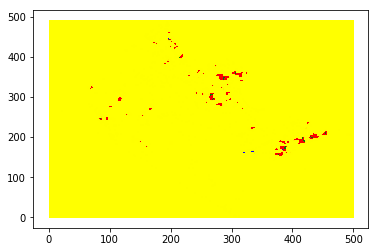

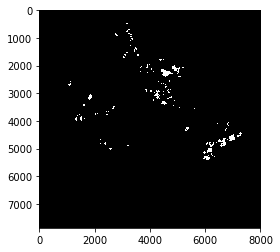

In [51]:
show_result(cloud_folder[4])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.431438127090301, FN ratio: 0.9852671199387437


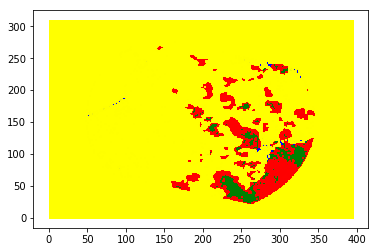

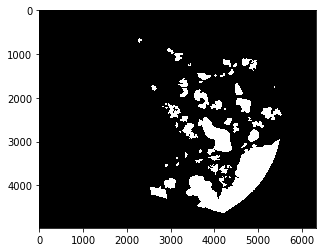

In [52]:
show_result(cloud_folder[5])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.8364087301587302, FN ratio: 0.9614334470989762


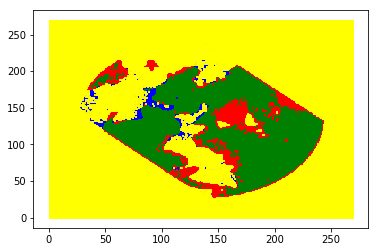

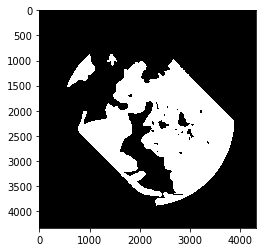

In [53]:
show_result(cloud_folder[6])

/usr/lib64/python3.4/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


TP ratio: 0.6338008013737836, FN ratio: 0.9945948457440218


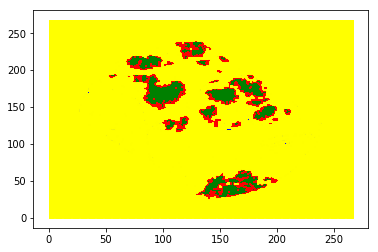

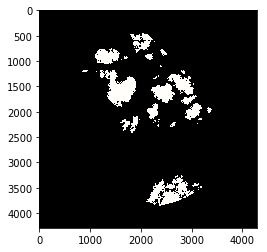

In [54]:
show_result(cloud_folder[7])